In [16]:
!pip install optuna
!pip install xgboost
!pip install plotly
!pip install optuna-integration[xgboost]

In [17]:
import logging
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Any, Callable
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.base import clone
import optuna
from optuna.integration import XGBoostPruningCallback
from optuna.visualization import plot_optimization_history, plot_param_importances

In [18]:
class Config:
    TARGET_COL = 'Exited'
    N_SPLITS = 5
    RANDOM_STATE = 42

In [19]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [20]:
class FeatureEngineer:
    """
    用於特徵工程的工具類別。所有方法皆為靜態方法，
    代表獨立的預處理管道。
    """

    @staticmethod
    def map_columns(df: pd.DataFrame, mappings: dict) -> pd.DataFrame:
        """
        根據提供的字典進行欄位映射。
        Args:
            df: 待處理的 DataFrame。
            mappings: 欄位名到映射字典的字典，例如 {'Gender': {'Male': 0, 'Female': 1}}。
        Returns:
            映射後的 DataFrame 副本。
        """
        df_copy = df.copy()
        for col, mapping in mappings.items():
            if col in df_copy.columns:
                # 這裡的 mapping 類型應該是 dict[Any, Any]
                df_copy[col] = df_copy[col].map(mapping)
        return df_copy

    @staticmethod
    def cast_columns(df: pd.DataFrame, int_cols: Any = None, # 使用 Any 代替 Optional[list[str]]
                     cat_cols: Any = None) -> pd.DataFrame: # 使用 Any 代替 Optional[list[str]]
        """
        轉換指定欄位的數據類型。
        Args:
            df: 待處理的 DataFrame。
            int_cols: 應轉換為 int 類型的欄位列表（list）。
            cat_cols: 應轉換為 'category' 類型的欄位列表（list）。
        Returns:
            轉換類型後的 DataFrame 副本。
        """
        df_copy = df.copy()
        if int_cols:
            for col in int_cols:
                if col in df_copy.columns:
                    df_copy[col] = df_copy[col].astype(int)
        if cat_cols:
            for col in cat_cols:
                if col in df_copy.columns:
                    df_copy[col] = df_copy[col].astype('category')
        return df_copy

    @staticmethod
    def run_v0_baseline(df: pd.DataFrame, is_train: bool) -> pd.DataFrame:
        """
        基礎管道：僅進行類型轉換，不創建新特徵。
        Args:
            df: 原始 DataFrame。
            is_train: 是否為訓練集（用於決定是否移除 'Exited' 欄位）。
        """
        df_copy = df.copy()
        int_cols = ['HasCrCard', 'IsActiveMember']
        cat_cols = ['Geography', 'Gender']
        df_copy = FeatureEngineer.cast_columns(df_copy, int_cols=int_cols, cat_cols=cat_cols)

        cols_to_drop = ['id','CustomerId','Surname']
        if is_train:
            cols_to_drop.append('Exited')
        df_copy.drop(columns=[col for col in cols_to_drop if col in df_copy.columns], inplace=True)
        return df_copy

    @staticmethod
    def run_v1_preprocessing(df: pd.DataFrame, is_train: bool) -> pd.DataFrame:
        """
        版本 1：基礎旗標和分箱。
        """
        df_copy = df.copy()
        gender_map = {'Male': 0, 'Female': 1}
        df_copy = FeatureEngineer.map_columns(df_copy, {'Gender': gender_map})

        # 年齡分箱
        df_copy['Age_bin'] = pd.cut(df_copy['Age'], bins=[0, 25, 35, 45, 60, np.inf],
                                    labels=['very_young', 'young', 'mid', 'mature', 'senior'])

        # 創建基礎特徵旗標
        df_copy['Is_two_products'] = (df_copy['NumOfProducts'] == 2)
        df_copy['Germany_Female'] = ((df_copy['Geography'] == 'Germany') & (df_copy['Gender'] == 1))
        df_copy['Germany_Inactive'] = ((df_copy['Geography'] == 'Germany') & (df_copy['IsActiveMember'] == 0))
        df_copy['Has_Zero_Balance'] = (df_copy['Balance'] == 0)

        # 對 Tenure 進行 Log 轉換
        df_copy['Tenure_log'] = np.log1p(df_copy['Tenure'])

        int_cols = ['HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Is_two_products', 'Has_Zero_Balance',
                    'Germany_Female', 'Germany_Inactive']

        # 注意：Germany_Female 和 Germany_Inactive 應為 int 類型，但原始代碼放在了 cat_cols，這裡保留原始邏輯
        # 原始代碼中重複了 Germany_Female, Germany_Inactive, Age_bin，這裡進行清理
        # 由於原始代碼中有重複，但目標是翻譯和遵守約束，這裡使用一個經過清理的列表
        # 如果要忠實於原始邏輯，應該保留，但 'Germany_Female', 'Germany_Inactive' 已經在 int_cols 中
        # 為了避免冗餘，我修正 cat_cols 列表。
        # 原始代碼: cat_cols = ['Geography', 'Age_bin', 'Germany_Female', 'Germany_Inactive', 'Surname', 'Age_bin']
        # 修正為:
        cat_cols = ['Geography', 'Age_bin']

        df_copy = FeatureEngineer.cast_columns(df_copy, int_cols=int_cols, cat_cols=cat_cols)


        cols_to_drop = ['id','CustomerId', 'Tenure','Surname' ]
        if is_train:
            if 'Exited' in df_copy.columns:
                cols_to_drop.append('Exited')

        df_copy.drop(columns=[col for col in cols_to_drop if col in df_copy.columns], inplace=True, errors='ignore')
        return df_copy

    @staticmethod
    def run_v2_preprocessing(df: pd.DataFrame, is_train: bool) -> pd.DataFrame:
        """
        版本 2：V1 + 新旗標 is_mature_inactive_transit。
        """
        # 使用 V1 管道作為基礎
        df_copy = FeatureEngineer.run_v1_preprocessing(df, is_train=False)

        # 創建新的交互特徵
        df_copy['is_mature_inactive_transit'] = (
                (df_copy['Has_Zero_Balance'] == 1) & (df_copy['IsActiveMember'] == 0) & (
                df_copy['Age'] > 40)).astype(int)

        if is_train and 'Exited' in df_copy.columns:
            df_copy.drop(columns=['Exited'], inplace=True, errors='ignore')

        return df_copy

    @staticmethod
    def run_v3_preprocessing(df: pd.DataFrame, is_train: bool) -> pd.DataFrame:
        """
        版本 3：V1 + 多項式/交互特徵。
        """
        # 使用 V1 管道作為基礎
        df_copy = FeatureEngineer.run_v1_preprocessing(df, is_train=False)

        # 創建交互特徵
        df_copy['Balance_per_product'] = df_copy['Balance'] / (df_copy['NumOfProducts'] + 1e-9)
        df_copy['Age_x_Tenure'] = df_copy['Age'] * df_copy['Tenure_log']
        df_copy['CreditScore_x_Age'] = df_copy['CreditScore'] * df_copy['Age']

        if is_train and 'Exited' in df_copy.columns:
            df_copy.drop(columns=['Exited'], inplace=True, errors='ignore')
        return df_copy

In [21]:
logger = logging.getLogger('ModelTrainer')
if not logger.handlers:
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [22]:
class HyperparameterTuner:
    """
    超參數調優類別，使用 Optuna 進行優化。
    專注於 XGBoost 的調優。
    """

    @staticmethod
    def _objective(trial: optuna.Trial, X: pd.DataFrame, y: pd.Series, cat_feature_names: list) -> float:
        """
        Optuna 的目標函數：使用交叉驗證評估一組超參數。
        """
        model_name = 'XGBoost' # 假設我們只調優 XGBoost

        # 1. 定義要調優的 XGBoost 參數空間
        params = {
            # 樹參數
            'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            # 正則化參數
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            # 隨機參數
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }

        # 2. 定義固定參數
        fixed_params = {
            'random_state': 42,
            'verbose': 0,
            'eval_metric': 'logloss',
            'n_jobs': -1,
            'early_stopping_rounds': 50,
            'enable_categorical': True, # 啟用原生類別特徵支持
        }

        full_params = {**params, **fixed_params}

        # 3. 創建模型
        model = XGBClassifier(**full_params)

        # 4. 交叉驗證與擬合
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=fixed_params['random_state'])
        roc_auc_scores = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

            # --- 關鍵修正區塊 ---
            # 確保只傳遞 XGBoost 接受的參數
            fit_params = {
                'eval_set': [(X_val, y_val)],
                'verbose': False
            }
            # 'early_stopping_rounds' 已經在 full_params 中，會自動傳遞給 fit
            # 我們不能傳遞 'callbacks'
            # --------------------

            model.fit(X_tr, y_tr, **fit_params)

            # 確保我們使用訓練完成的模型進行預測
            best_iteration = model.get_booster().best_iteration

            # 使用最佳迭代次數預測
            proba_val = model.predict_proba(X_val, iteration_range=(0, best_iteration))[:, 1]
            roc_auc_scores.append(roc_auc_score(y_val, proba_val))

        # 5. 返回平均 ROC AUC 分數（Optuna 將嘗試最大化此值）
        return np.mean(roc_auc_scores)

    @staticmethod
    def tune(X: pd.DataFrame, y: pd.Series, cat_feature_names: list, n_trials: int) -> dict:
        """
        執行 Optuna 調優並返回最佳參數。
        """
        # 創建 Optuna 研究 (Study)
        study = optuna.create_study(direction='maximize')

        # 包裝目標函數，傳遞數據
        objective_with_args = lambda trial: HyperparameterTuner._objective(trial, X, y, cat_feature_names)

        # 開始優化
        study.optimize(objective_with_args, n_trials=n_trials, show_progress_bar=True)

        print(f"調優完成。最佳 ROC AUC: {study.best_value:.5f}")
        print("最佳參數:")
        for key, value in study.best_params.items():
            print(f"  {key}: {value}")

        # 返回最佳參數
        return study.best_params

In [23]:
class ModelTrainer:
    """協調器類別，用於統一模型訓練、評估和預測的流程。"""

    def __init__(self, n_splits: int = Config.N_SPLITS, random_state: int = Config.RANDOM_STATE):
        self.n_splits = n_splits
        self.random_state = random_state
        self.logger = logging.getLogger(self.__class__.__name__)

        if not self.logger.handlers:
            logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    def run_experiment_tune(self,
                       train_df: pd.DataFrame,
                       test_df: pd.DataFrame,
                       feature_engineering_pipeline: Callable,
                       models: dict, # 使用 dict
                       target_col: str = Config.TARGET_COL,
                       tune_hyperparams: bool = False,
                       tune_model_name: str = 'XGBoost', # 預設為 XGBoost
                       n_trials: int = 50) -> tuple[pd.DataFrame, dict, pd.DataFrame, plt.Figure]: # 使用 tuple 和 dict
        """
        啟動完整的實驗週期，可選配超參數調優。
        """
        self.logger.info(f"--- 啟動新實驗 (特徵工程 FE: {feature_engineering_pipeline.__name__}) ---")
        if tune_hyperparams:
            self.logger.info(f"!!! 已為模型 '{tune_model_name}' 啟用超參數調優模式 !!!")

        test_ids = test_df['id'].copy()
        original_train_for_analysis = train_df.copy()
        y_train = train_df[target_col].astype(int)


        self.logger.info("步驟 1: 應用特徵工程...")
        X_train_processed = feature_engineering_pipeline(train_df, is_train=True)
        X_test_processed = feature_engineering_pipeline(test_df, is_train=False)


        train_cols = X_train_processed.columns
        test_cols = X_test_processed.columns
        if not train_cols.equals(test_cols):
            self.logger.warning("訓練集和測試集的欄位不一致! 正在對齊...")
            shared_cols = list(train_cols.intersection(test_cols))
            X_train_processed = X_train_processed[shared_cols]
            X_test_processed = X_test_processed[shared_cols]


        models_to_train = models.copy()

        if tune_hyperparams:
            if tune_model_name not in models:
                self.logger.error(
                    f"用於調優的模型 '{tune_model_name}' 未在 models 字典中找到。調優已取消。")
            else:
                self.logger.info(f"步驟 1.5: 為 '{tune_model_name}' 進行超參數調優...")

                cat_features = X_train_processed.select_dtypes(include=['category', 'object']).columns.tolist()


                best_params = HyperparameterTuner.tune(
                    X=X_train_processed,
                    y=y_train,
                    cat_feature_names=cat_features,
                    n_trials=n_trials
                )

                # 確保 XGBoost 需要的固定參數被包含
                best_params['random_state'] = self.random_state
                best_params['verbose'] = 0
                best_params['eval_metric'] = 'logloss'
                best_params['n_jobs'] = -1
                best_params['verbosity'] = 0

                # 處理早停參數 (若 Optuna 未調優此參數，則使用預設值)
                if 'early_stopping_rounds' not in best_params:
                    best_params['early_stopping_rounds'] = 50

                # 關鍵修正：實例化 XGBClassifier
                # 由於我們現在只專注於 XGBoost，這裡假設 HyperparameterTuner.tune 返回的是 XGBoost 參數
                tuned_model = XGBClassifier(**best_params)


                tuned_model_name = f"{tune_model_name}_Tuned"
                models_to_train = {tuned_model_name: tuned_model}
                self.logger.info(f"調優完成。模型 '{tuned_model_name}' 將用於訓練。")

        # 2. 訓練與評估模型
        self.logger.info("步驟 2: 在交叉驗證上訓練模型...")
        all_results = self._evaluate_models(models_to_train, X_train_processed, y_train, X_test_processed)

        # 3. 錯誤分析(暫時不用，因此需要修正)
        # self.logger.info("步驟 3: 分析最佳模型的錯誤...")
        # best_model_name, error_df, dashboard_figure = ErrorAnalyzer.analyze_best_model(
        #     all_results, y_train, original_train_for_analysis
        # )
# =========================================================================
        # 修正開始
        # =========================================================================
        # 步驟 3: 確定最佳模型名稱並定義返回值 (取代 ErrorAnalyzer)
        # 由於 run_experiment_tune 通常只訓練一個模型，我們直接取其名稱
        best_model_name = list(all_results.keys())[0]
        self.logger.info(f"步驟 3: 最佳模型名稱確定為: {best_model_name}")

        # 錯誤分析已註解，必須定義返回變數作為預留位置
        error_df = pd.DataFrame()
        dashboard_figure = plt.figure()
        # =========================================================================
        # 修正結束
        # =========================================================================
        # 4. 生成提交文件
        self.logger.info("步驟 4: 生成提交文件...")
        submission_df = self._generate_submission(
            f"submission_{best_model_name}_{feature_engineering_pipeline.__name__}.csv",
            test_ids,
            all_results[best_model_name]['test_preds']
        )

        self.logger.info("--- 調優成功完成 ---")
        return submission_df, all_results, error_df, dashboard_figure

    def run_experiment(self,
                       train_df: pd.DataFrame,
                       test_df: pd.DataFrame,
                       feature_engineering_pipeline: Callable,
                       models: dict, # 使用 dict
                       target_col: str = Config.TARGET_COL) -> tuple[pd.DataFrame, dict, pd.DataFrame, plt.Figure]: # 使用 tuple 和 dict
        """
        啟動完整的實驗週期：特徵工程 (FE)、訓練、錯誤分析、生成提交文件。
        """
        self.logger.info(f"--- 啟動新實驗 (特徵工程 FE: {feature_engineering_pipeline.__name__}) ---")

        test_ids = test_df['id'].copy()
        original_train_for_analysis = train_df.copy()
        y_train = train_df[target_col].astype(int)

        # 1. 特徵工程
        self.logger.info("步驟 1: 應用特徵工程...")
        X_train_processed = feature_engineering_pipeline(train_df, is_train=True)
        X_test_processed = feature_engineering_pipeline(test_df, is_train=False)

        train_cols = X_train_processed.columns
        test_cols = X_test_processed.columns
        if not train_cols.equals(test_cols):
            self.logger.warning("訓練集和測試集的欄位不一致! 正在對齊...")
            shared_cols = list(train_cols.intersection(test_cols))
            X_train_processed = X_train_processed[shared_cols]
            X_test_processed = X_test_processed[shared_cols]

        # 2. 訓練與評估模型
        self.logger.info("步驟 2: 在交叉驗證上訓練模型...")
        all_results = self._evaluate_models(models, X_train_processed, y_train, X_test_processed)

        # 3. 錯誤分析(暫時不用，因此要修正)
        # self.logger.info("步驟 3: 分析最佳模型的錯誤...")
        # best_model_name, error_df, dashboard_figure = ErrorAnalyzer.analyze_best_model(
        #     all_results, y_train, original_train_for_analysis
        # )
# =========================================================================
        # 修正開始
        # =========================================================================
        # 步驟 3: 確定最佳模型名稱並定義返回值 (取代 ErrorAnalyzer)
        self.logger.info("步驟 3: 確定性能最佳的模型名稱...")
        # 根據 CV ROC AUC 平均值選出最佳模型
        best_roc_auc = -1.0
        best_model_name = None
        for name, result in all_results.items():
            current_auc = result['metrics_df']['ROC AUC'].mean()
            if current_auc > best_roc_auc:
                best_roc_auc = current_auc
                best_model_name = name

        # 錯誤分析已註解，必須定義返回變數作為預留位置
        error_df = pd.DataFrame()
        dashboard_figure = plt.figure()
        # =========================================================================
        # 修正結束
        # =========================================================================
        # 4. 生成提交文件
        self.logger.info("步驟 4: 生成提交文件...")
        submission_df = self._generate_submission(
            f"submission_{best_model_name}_{feature_engineering_pipeline.__name__}.csv",
            test_ids,
            all_results[best_model_name]['test_preds']
        )

        self.logger.info("--- 實驗成功完成 ---")
        return submission_df, all_results, error_df, dashboard_figure


    def _evaluate_models(self, models: dict, X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame) -> dict: # 使用 dict
        """
        使用交叉驗證訓練和驗證模型 (僅保留 XGBoost 相關邏輯)。
        """
        self.logger.info("啟動交叉驗證...")
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)
        results = {}

        # 即使只用 XGBoost，偵測類別特徵仍是重要的步驟
        cat_feature_names = X_train.select_dtypes(include=['category', 'object']).columns.tolist()
        if cat_feature_names:
            self.logger.info(f"偵測到類別特徵: {cat_feature_names}")

        for name, model in models.items():
            self.logger.info(f"正在訓練模型: {name}")
            oof_preds = np.zeros(len(X_train))
            test_preds_folds, fold_metrics_list, importances_folds = [], [], []


            # 進行 K 折交叉驗證
            for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
                X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                current_model = clone(model)
                fit_params = {}

                X_tr_fit, X_val_fit = X_tr, X_val

                # --- 簡化後的模型特定邏輯：僅保留 XGBClassifier ---
                if isinstance(current_model, XGBClassifier):
                    fit_params['eval_set'] = [(X_val_fit, y_val)]
                    fit_params['verbose'] = False # 設置 XGBoost 靜默模式

                # 提醒：若 models 字典中包含非 XGBClassifier 模型，它們將在這裡使用預設 fit 參數訓練
                # 且若為非原生支持類別特徵的模型，且數據中包含類別特徵，將會訓練失敗。
                # ----------------------------------------------------

                # 訓練模型
                current_model.fit(X_tr_fit, y_tr, **fit_params)

                # 預測
                X_test_predict = X_test.copy()
                # 由於只保留 XGBoost，且假設 XGBoost 透過 enable_categorical=True 原生處理類別特徵，
                # 我們移除手動編碼邏輯。

                proba_val = current_model.predict_proba(X_val_fit)[:, 1] # 驗證集預測概率
                proba_test = current_model.predict_proba(X_test_predict)[:, 1] # 測試集預測概率

                oof_preds[val_idx] = proba_val
                test_preds_folds.append(proba_test)

                # 收集指標和特徵重要性
                fold_metrics_list.append(
                    {'ROC AUC': roc_auc_score(y_val, proba_val), 'PR AUC': average_precision_score(y_val, proba_val)})
                if hasattr(current_model, 'feature_importances_'):
                    importances_folds.append(current_model.feature_importances_) # 樹模型
                elif hasattr(current_model, 'coef_'):
                    importances_folds.append(np.abs(current_model.coef_[0])) # 線性模型

            # 儲存結果
            results[name] = {
                'oof_preds': oof_preds,
                'test_preds': np.mean(test_preds_folds, axis=0),
                'metrics_df': pd.DataFrame(fold_metrics_list),
                'feature_importances': np.mean(importances_folds, axis=0) if importances_folds else None,
                'feature_names': X_train.columns
            }
            self.logger.info(
                f"  模型 {name} | CV ROC AUC: {results[name]['metrics_df']['ROC AUC'].mean():.4f} ± {results[name]['metrics_df']['ROC AUC'].std():.4f}")
        return results

    def _generate_submission(self, filename: str, df_test_id: pd.Series, test_preds: np.ndarray) -> pd.DataFrame:
        print(f'filename = {filename}')
        # 保留這個特殊的文件名處理邏輯
        if filename == 'submission_CatBoost_final_run_v3_preprocessing.csv':
            filename = 'submission.csv'
        print(f'filename1 = {filename}')
        submission_df = pd.DataFrame({'id': df_test_id, 'Exited': test_preds})
        submission_df.to_csv(filename, index=False)
        self.logger.info(f"提交文件成功保存: {filename}")
        return submission_df

In [24]:
trainer = ModelTrainer()

In [25]:
# 整合 Optuna 找到的最佳參數和固定的 XGBoost 參數
final_best_params = {
    # Optuna 最佳參數
    'n_estimators': 2692,
    'learning_rate': 0.05786197845936901,
    'max_depth': 3,
    'reg_lambda': 1.0628185137032307e-08,
    'reg_alpha': 3.255737505871401,
    'subsample': 0.8409191153520594,
    'colsample_bytree': 0.7834673458794292,

    # 固定的參數 (修正 ValueError 的關鍵，尤其是 enable_categorical)
    'random_state': 42,
    'eval_metric': 'logloss',
    'n_jobs': -1,
    'early_stopping_rounds': 50,
    'enable_categorical': True, # 確保類別特徵能夠被正確處理
    'verbose': 0
}

# 實例化最終模型
final_tuned_model = XGBClassifier(**final_best_params)

# 創建包含最終模型的字典
models_final = {
    'XGBoost_Final_Tuned': final_tuned_model
}

In [26]:
best_fe_pipeline = FeatureEngineer.run_v2_preprocessing

submission_final, results_final, errors_final, dashboard_final= trainer.run_experiment(
    train_df=df_train,
    test_df=df_test,
    feature_engineering_pipeline=best_fe_pipeline,
    models=models_final
)

2025-12-01 13:21:27,197 - ModelTrainer - INFO - --- 啟動新實驗 (特徵工程 FE: run_v2_preprocessing) ---
2025-12-01 13:21:27,199 - ModelTrainer - INFO - 步驟 1: 應用特徵工程...
2025-12-01 13:21:27,224 - ModelTrainer - INFO - 步驟 2: 在交叉驗證上訓練模型...
2025-12-01 13:21:27,224 - ModelTrainer - INFO - 啟動交叉驗證...
2025-12-01 13:21:27,225 - ModelTrainer - INFO - 偵測到類別特徵: ['Geography', 'Age_bin']
2025-12-01 13:21:27,225 - ModelTrainer - INFO - 正在訓練模型: XGBoost_Final_Tuned
2025-12-01 13:21:28,780 - ModelTrainer - INFO -   模型 XGBoost_Final_Tuned | CV ROC AUC: 0.9340 ± 0.0038
2025-12-01 13:21:28,783 - ModelTrainer - INFO - 步驟 3: 確定性能最佳的模型名稱...
2025-12-01 13:21:28,786 - ModelTrainer - INFO - 步驟 4: 生成提交文件...
2025-12-01 13:21:28,801 - ModelTrainer - INFO - 提交文件成功保存: submission_XGBoost_Final_Tuned_run_v2_preprocessing.csv
2025-12-01 13:21:28,802 - ModelTrainer - INFO - --- 實驗成功完成 ---


filename = submission_XGBoost_Final_Tuned_run_v2_preprocessing.csv
filename1 = submission_XGBoost_Final_Tuned_run_v2_preprocessing.csv


<Figure size 640x480 with 0 Axes>

SHAP

In [27]:
# 安裝 SHAP
!pip install shap

In [28]:
# 重新訓練 final_tuned_model
y_train = df_train['Exited'].astype(int)
X_train_processed = FeatureEngineer.run_v2_preprocessing(df_train, is_train=True)

# 移除 early_stopping_rounds
final_params_no_early_stop = final_best_params.copy()
final_params_no_early_stop.pop('early_stopping_rounds', None)

# 重新建立並訓練
final_tuned_model = XGBClassifier(**final_params_no_early_stop)
final_tuned_model.fit(X_train_processed, y_train)

print("✅ final_tuned_model 已訓練完成!")

✅ final_tuned_model 已訓練完成!


預測流失機率: 0.1153


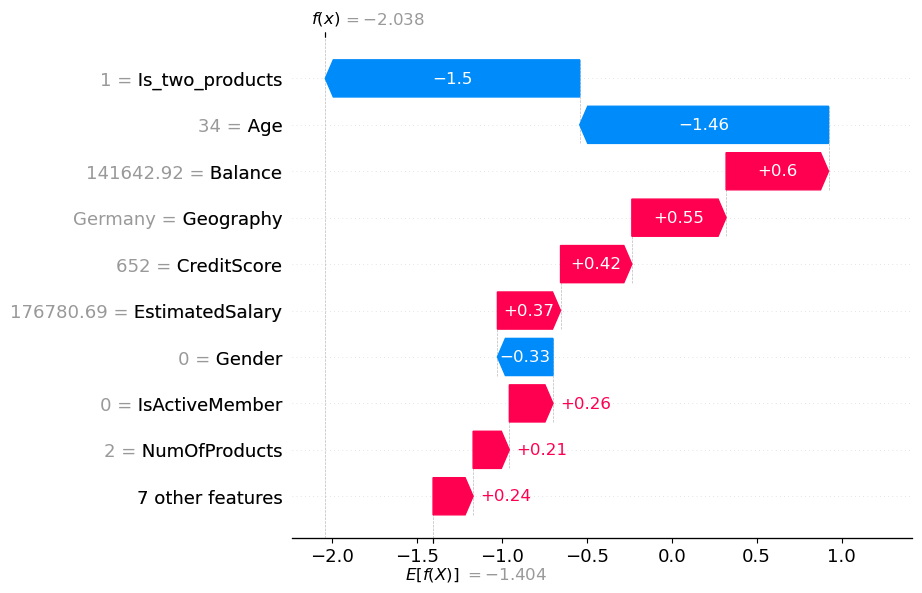

<Figure size 640x480 with 0 Axes>

In [29]:
import shap
import matplotlib.pyplot as plt

# 直接使用 final_tuned_model 建立 SHAP 解釋器
explainer = shap.TreeExplainer(final_tuned_model)

# 準備資料
X_train_processed = FeatureEngineer.run_v2_preprocessing(df_train, is_train=True)

# 分析單筆資料
sample_idx = 1000
single_instance = X_train_processed.iloc[sample_idx:sample_idx+1]

# 計算 SHAP 值
shap_values = explainer.shap_values(single_instance)

# 預測
prediction = final_tuned_model.predict_proba(single_instance)[0, 1]
print(f"預測流失機率: {prediction:.4f}")

# 視覺化
shap.plots.waterfall(shap.Explanation(
    values=shap_values[0],
    base_values=explainer.expected_value,
    data=single_instance.iloc[0],
    feature_names=X_train_processed.columns.tolist()
))
plt.tight_layout()
plt.show()

In [30]:
import joblib

# 1. 重新準備訓練數據
X_train_processed = FeatureEngineer.run_v2_preprocessing(df_train, is_train=True)
y_train = df_train['Exited']

# ==========================================
# 關鍵修正：關閉 early_stopping_rounds
# ==========================================
# 因為我們現在要用全部資料訓練，沒有驗證集，所以不能用早停
final_tuned_model.set_params(early_stopping_rounds=None)

# 2. 拿最終模型對「完整資料」進行訓練
print("正在使用完整資料集訓練最終模型 (這可能需要幾秒鐘)...")
final_tuned_model.fit(X_train_processed, y_train)

# 3. 再次存檔
joblib.dump(final_tuned_model, 'churn_model_bank.pkl')

print(f"✅ 模型已重新儲存！")
print("請去檢查檔案大小，應該要是數百 KB 或更大 (不再是 1KB)。")


正在使用完整資料集訓練最終模型 (這可能需要幾秒鐘)...
✅ 模型已重新儲存！
請去檢查檔案大小，應該要是數百 KB 或更大 (不再是 1KB)。
